In [1]:
## Auto-format notebook
%load_ext lab_black

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.onnx
import shutil
from time import strftime, time
from collections import deque, namedtuple
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import IPython.display
from functools import partial
from itertools import chain

import gym
from gym import Env, Wrapper

from pommerman import make
from pommerman.agents import BaseAgent, RandomAgent, SimpleAgent
from graphic_pomme_env import graphic_pomme_env
from graphic_pomme_env.wrappers import PommerEnvWrapperFrameSkip2

print(
    '''Hint: just ignore the error "Import error NSDE! You will not be able to render --> Cannot connect to 'None'"'''
)
pomenvs = [es.id for es in gym.envs.registry.all() if es.id.startswith("Pomme")]
print("\n".join(pomenvs))
res = graphic_pomme_env.load_resources()
N_PLAYERS = 2
NUM_STACK = 5

NUM_ACTIONS = 6
"""
0 Stop
1 Up
2 Down
3 Left
4 Right
5 Bomb
"""

['/home/raphael/uni/jku/2_sem/reinforcement_learning/assignments', '/home/raphael/.pyenv/versions/3.7.12/lib/python37.zip', '/home/raphael/.pyenv/versions/3.7.12/lib/python3.7', '/home/raphael/.pyenv/versions/3.7.12/lib/python3.7/lib-dynload', '', '/home/raphael/.local/share/virtualenvs/assignments-geAH-P9e/lib/python3.7/site-packages', '/home/raphael/.local/share/virtualenvs/assignments-geAH-P9e/lib/python3.7/site-packages/IPython/extensions', '/home/raphael/.ipython']
/home/raphael/.local/share/virtualenvs/assignments-geAH-P9e/lib/python3.7/site-packages
['/home/raphael/.local/share/virtualenvs/assignments-geAH-P9e/lib/python3.7/site-packages', '/home/raphael/uni/jku/2_sem/reinforcement_learning/assignments', '/home/raphael/.pyenv/versions/3.7.12/lib/python37.zip', '/home/raphael/.pyenv/versions/3.7.12/lib/python3.7', '/home/raphael/.pyenv/versions/3.7.12/lib/python3.7/lib-dynload', '', '/home/raphael/.local/share/virtualenvs/assignments-geAH-P9e/lib/python3.7/site-packages', '/home/

'\n0 Stop\n1 Up\n2 Down\n3 Left\n4 Right\n5 Bomb\n'

In [3]:
import csv
from IPython.display import clear_output

In [9]:
class ReplayBuffer:
    def __init__(self, num_actions, size=10_000, remove_low_reward=0.8):
        self.size = size
        self.transition = []
        self.num_actions = num_actions
        self.remove_low_reward = remove_low_reward

    def add(self, state, action, reward, next_state, done):
        if self.length() > self.size:
            self.remove()
        self.transition.append((state, action, reward, next_state, done))

    def length(self):
        return len(self.transition)

    def remove(self):
        idx = 0
        if np.random.random() < self.remove_low_reward:

            lowest_reward = min(self.transition, key=lambda x: x[2])[2]

            for i, t in enumerate(self.transition):
                if t[2] == lowest_reward:
                    self.transition.pop(i)
                    break

        else:
            self.transition.pop(idx)

    def sample_batch(self, batch_size):
        batch = random.sample(self.transition, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        actions = torch.from_numpy(actions.astype(int)).to(device, dtype=torch.int)
        rewards = torch.from_numpy(rewards).to(device, dtype=torch.float32)
        dones = torch.from_numpy(dones.astype(int)).to(device, dtype=torch.int)

        return states, actions, rewards, next_states, dones

    def store_to_file(self):
        states, actions, rewards, next_states, dones = map(
            np.array, zip(*self.transition)
        )

        np.save("immitation_states_2_static.npy", states, allow_pickle=True)
        np.save("immitation_actions_2_static.npy", actions, allow_pickle=True)

In [10]:
def get_random_environment(oponent, random_env):
    # since this is also used for evaluation I see no need to train for different values atm
    env = PommerEnvWrapperFrameSkip2(num_stack=5, start_pos=0, opponent_actor=oponent)

    if random_env:
        n_rigid = np.random.randint(low=1, high=6) * 2
        n_wood = np.random.randint(low=3, high=7) * 2
        n_items = np.random.randint(low=1, high=n_wood)

        env.set_board_params(num_rigid=n_rigid, num_wood=n_wood, num_items=n_items)

    return env

In [11]:
def static_agent(frame_stack):
    del frame_stack
    return 0


def rand_no_bomb_agent(frame_stack):
    del frame_stack
    return np.random.randint(NUM_ACTIONS - 1)


def rand_agent(frame_stack):
    return np.random.randint(NUM_ACTIONS)


def model_agent(frame_stack, model):
    with torch.no_grad():
        obs = torch.from_numpy(np.array(frame_stack.get_obersvation()))
        net_out = model(obs).detach().cpu().numpy()

    action = np.argmax(net_out)
    return action

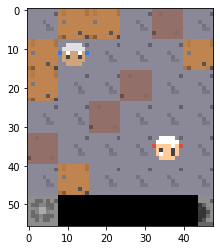

In [7]:
env = PommerEnvWrapperFrameSkip2(num_stack=5, start_pos=0)
env.set_board_params(num_rigid=2, num_wood=10, num_items=2)

obs, _ = env.reset()
rgb_img = np.array(env.get_rgb_img())
plt.imshow(Image.fromarray(rgb_img))

env.set_board_params(num_rigid=4, num_wood=6, num_items=2)

obs, _ = env.reset()
rgb_img = np.array(env.get_rgb_img())
plt.imshow(Image.fromarray(rgb_img))

In [12]:
env = get_random_environment(static_agent, False)

buffer = ReplayBuffer(6, 100_000)


for i in range(40):
    print("Starting new round")
    done = False
    timesteps = 0
    bomb_timestep = []
    agent_obs, opponent_obs = env.reset()
    while not done:
        agent_obs = np.array(agent_obs).astype(np.uint8)

        # rgb_img = np.array(env.get_rgb_img())

        plt.imshow(Image.fromarray(agent_obs[-1]))
        plt.show()

        a = input("\n0 Stop\n1 Up\n2 Down\n3 Left\n4 Right\n5 Bomb\n")
        print(a)
        if a != "0" and a != "1" and a != "2" and a != "3" and a != "4" and a != "5":
            a = input("\n0 Stop\n1 Up\n2 Down\n3 Left\n4 Right\n5 Bomb\n")
        if a != "0" and a != "1" and a != "2" and a != "3" and a != "4" and a != "5":
            a = input("\n0 Stop\n1 Up\n2 Down\n3 Left\n4 Right\n5 Bomb\n")
        a = int(a)

        clear_output()

        agent_step, oponent_step = env.step(a)
        next_agent_obs, r, done, info = agent_step
        print(info)
        next_agent_obs = np.array(next_agent_obs).astype(np.uint8)

        r = r * 200  # winning or loosing is now +200 / -200

        if a == 5:  # if action == bomb
            bomb_timestep.append(timesteps)

        for b_t in bomb_timestep:
            if timesteps - b_t == 10 and not done:
                bomb_timestep.remove(b_t)
                r = r + 0.2

        buffer.add(agent_obs, a, r, next_agent_obs, done)
        agent_obs = next_agent_obs

buffer.store_to_file()

{'result': <Result.Win: 0>, 'winners': [0]}


In [ ]:
first = np.load("immitation_states.npy", allow_pickle=True)
second = np.load("immitation_states_1.npy", allow_pickle=True)

print(first.shape)
print(second.shape)

combined_states = np.concatenate((first, second), axis=0)

np.save("demo_states.npy", combined_states, allow_pickle=True)

In [ ]:
afirst = np.load("immitation_actions.npy", allow_pickle=True)
asecond = np.load("immitation_actions_2_static.npy", allow_pickle=True)

print(afirst.shape)
print(asecond.shape)

combined_actions = np.concatenate((afirst, asecond), axis=0)
print(combined_actions.shape)

np.save("demo_actions.npy", combined_actions, allow_pickle=True)